# Predicting the closing price stock prices

In [21]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stocks import api

In [22]:
stocks = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

raw_df = api.yf_with_params(tickers=stocks, period="5y")

[*********************100%***********************]  4 of 4 completed


In [23]:
df = raw_df.copy()
df = df.stack(0).reset_index()
df = df.rename(columns={"level_0": "Date", "level_1": "Stock"})
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Stock,Adj Close,Close,High,Low,Open,Volume
0,2017-10-16 00:00:00-04:00,AAPL,37.934139,39.970001,40.000000,39.412498,39.474998,96486000
1,2017-10-16 00:00:00-04:00,AMZN,50.317001,50.317001,50.478500,50.051998,50.422001,40178000
2,2017-10-16 00:00:00-04:00,GOOG,49.599998,49.599998,49.695351,49.200001,49.605000,18210000
3,2017-10-16 00:00:00-04:00,MSFT,72.963799,77.650002,77.809998,77.349998,77.419998,12380100
4,2017-10-17 00:00:00-04:00,AAPL,38.074131,40.117500,40.217499,39.807499,39.945000,75989200
...,...,...,...,...,...,...,...,...
5031,2022-10-13 00:00:00-04:00,MSFT,234.240005,234.240005,236.100006,219.130005,219.850006,42551800
5032,2022-10-14 00:00:00-04:00,AAPL,138.380005,138.380005,144.520004,138.190002,144.309998,88512300
5033,2022-10-14 00:00:00-04:00,AMZN,106.900002,106.900002,114.959999,106.599998,114.099998,67651200
5034,2022-10-14 00:00:00-04:00,GOOG,97.180000,97.180000,101.290001,97.029999,100.625000,22612900


In [24]:
df = df.filter(["Date", "Stock", "Adj Close"])
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(df) * .95 ))

subsets = {"train": df.iloc[:training_data_len, :], "val": df.iloc[training_data_len:, :]}
subsets["train"], subsets["val"]

(                          Date Stock   Adj Close
 0    2017-10-16 00:00:00-04:00  AAPL   37.934139
 1    2017-10-16 00:00:00-04:00  AMZN   50.317001
 2    2017-10-16 00:00:00-04:00  GOOG   49.599998
 3    2017-10-16 00:00:00-04:00  MSFT   72.963799
 4    2017-10-17 00:00:00-04:00  AAPL   38.074131
 ...                        ...   ...         ...
 4780 2022-07-18 00:00:00-04:00  AAPL  146.865997
 4781 2022-07-18 00:00:00-04:00  AMZN  113.760002
 4782 2022-07-18 00:00:00-04:00  GOOG  109.910004
 4783 2022-07-18 00:00:00-04:00  MSFT  253.711472
 4784 2022-07-19 00:00:00-04:00  AAPL  150.790543
 
 [4785 rows x 3 columns],
                           Date Stock   Adj Close
 4785 2022-07-19 00:00:00-04:00  AMZN  118.209999
 4786 2022-07-19 00:00:00-04:00  GOOG  114.620003
 4787 2022-07-19 00:00:00-04:00  MSFT  258.980286
 4788 2022-07-20 00:00:00-04:00  AAPL  152.827713
 4789 2022-07-20 00:00:00-04:00  AMZN  122.769997
 ...                        ...   ...         ...
 5031 2022-10-13 00:00

In [25]:
def add_features(df, n: int = 1):
    df = df.copy()
    df["close_next"] = df.groupby("Stock")["Adj Close"].shift(-1)
    
    for i in range(1, n + 1):
        df[f"close_lag_{i}"] = df.groupby("Stock")["Adj Close"].shift(i)
        df[f"close_diff_{i}"] = df.groupby("Stock")["Adj Close"].diff(i)
    
    df["close_mean_4"] = df.groupby("Stock")["Adj Close"].rolling(4).mean().reset_index(level=0, drop=True)
    df["week_day"] = df["Date"].dt.weekday
    df["month_day"] = df["Date"].dt.day
    df["week"] = df["Date"].dt.isocalendar().week
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year
    df = df.dropna()
    return df

subsets["train"] = add_features(subsets["train"], 10)
subsets["val"] = add_features(subsets["val"], 10)

subsets["train"]

,Date,Stock,Adj Close,close_next,close_lag_1,close_diff_1,close_lag_2,close_diff_2,close_lag_3,close_diff_3,...,close_lag_9,close_diff_9,close_lag_10,close_diff_10,close_mean_4,week_day,month_day,week,month,year
40,2017-10-30 00:00:00-04:00,AAPL,39.557049,40.107506,38.686275,0.870773,37.348103,2.208946,37.110832,2.446217,...,38.074131,1.482918,37.934139,1.622910,38.175565,0,30,44,10,2017
41,2017-10-30 00:00:00-04:00,AMZN,55.542500,55.264000,55.047501,0.494999,48.621498,6.921001,48.645500,6.896999,...,50.456501,5.085999,50.317001,5.225498,51.964250,0,30,44,10,2017
42,2017-10-30 00:00:00-04:00,GOOG,50.855499,50.832001,50.963501,-0.108002,48.627998,2.227501,48.666500,2.188999,...,49.609001,1.246498,49.599998,1.255501,49.778375,0,30,44,10,2017
43,2017-10-30 00:00:00-04:00,MSFT,78.827209,78.160072,78.752029,0.075180,74.006821,4.820389,73.884636,4.942574,...,72.907433,5.919777,72.963799,5.863411,76.367674,0,30,44,10,2017
44,2017-10-31 00:00:00-04:00,AAPL,40.107506,39.597385,39.557049,0.550457,38.686275,1.421230,37.348103,2.759403,...,37.905674,2.201832,38.074131,2.033375,38.924733,1,31,44,10,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,2022-07-15 00:00:00-04:00,AAPL,149.961700,146.865997,148.264053,1.697647,145.288193,4.673508,145.657669,4.304031,...,138.737274,11.224426,136.530350,13.431351,147.292904,4,15,28,7,2022
4777,2022-07-15 00:00:00-04:00,AMZN,113.550003,113.760002,110.629997,2.920006,110.400002,3.150002,109.220001,4.330002,...,109.559998,3.990005,106.209999,7.340004,110.950001,4,15,28,7,2022
4778,2022-07-15 00:00:00-04:00,GOOG,112.766998,109.910004,111.440002,1.326996,112.186996,0.580002,114.849503,-2.082504,...,109.081001,3.685997,109.372498,3.394501,112.810875,4,15,28,7,2022
4779,2022-07-15 00:00:00-04:00,MSFT,256.176239,253.711472,253.541840,2.634399,252.184708,3.991531,253.132690,3.043549,...,259.030182,-2.853943,256.285980,-0.109741,253.758869,4,15,28,7,2022


In [26]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Baseline
y_pred = subsets["val"]["close_next"]
y_true = subsets["val"]["Adj Close"]

wmape(y_true, y_pred)

0.015392198484389085

In [27]:
from sklearn.ensemble import RandomForestRegressor

features = ["close_lag_1", "close_diff_1", "week_day", "month_day",	"week",	"month"]
target = "close_next"

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(subsets["train"][features], subsets["train"][target])

y_pred = mdl.predict(subsets["val"][features])
subsets["val"]["pred_close_next"] = y_pred
subsets["val"]["pred_close"] = subsets["val"].groupby("Stock")["pred_close_next"].shift(1)

wmape(y_true, y_pred)

0.01064752015911629

In [28]:
dataset = pd.concat(subsets.values(), axis=0)
melt_df = dataset.melt(id_vars=["Date", "Stock"], value_vars=["Adj Close", "pred_close"])
melt_df

,Date,Stock,variable,value
0,2017-10-30 00:00:00-04:00,AAPL,Adj Close,39.557049
1,2017-10-30 00:00:00-04:00,AMZN,Adj Close,55.542500
2,2017-10-30 00:00:00-04:00,GOOG,Adj Close,50.855499
3,2017-10-30 00:00:00-04:00,MSFT,Adj Close,78.827209
4,2017-10-31 00:00:00-04:00,AAPL,Adj Close,40.107506
...,...,...,...,...
9891,2022-10-12 00:00:00-04:00,MSFT,pred_close,225.505538
9892,2022-10-13 00:00:00-04:00,AAPL,pred_close,139.710742
9893,2022-10-13 00:00:00-04:00,AMZN,pred_close,114.153155
9894,2022-10-13 00:00:00-04:00,GOOG,pred_close,98.696426


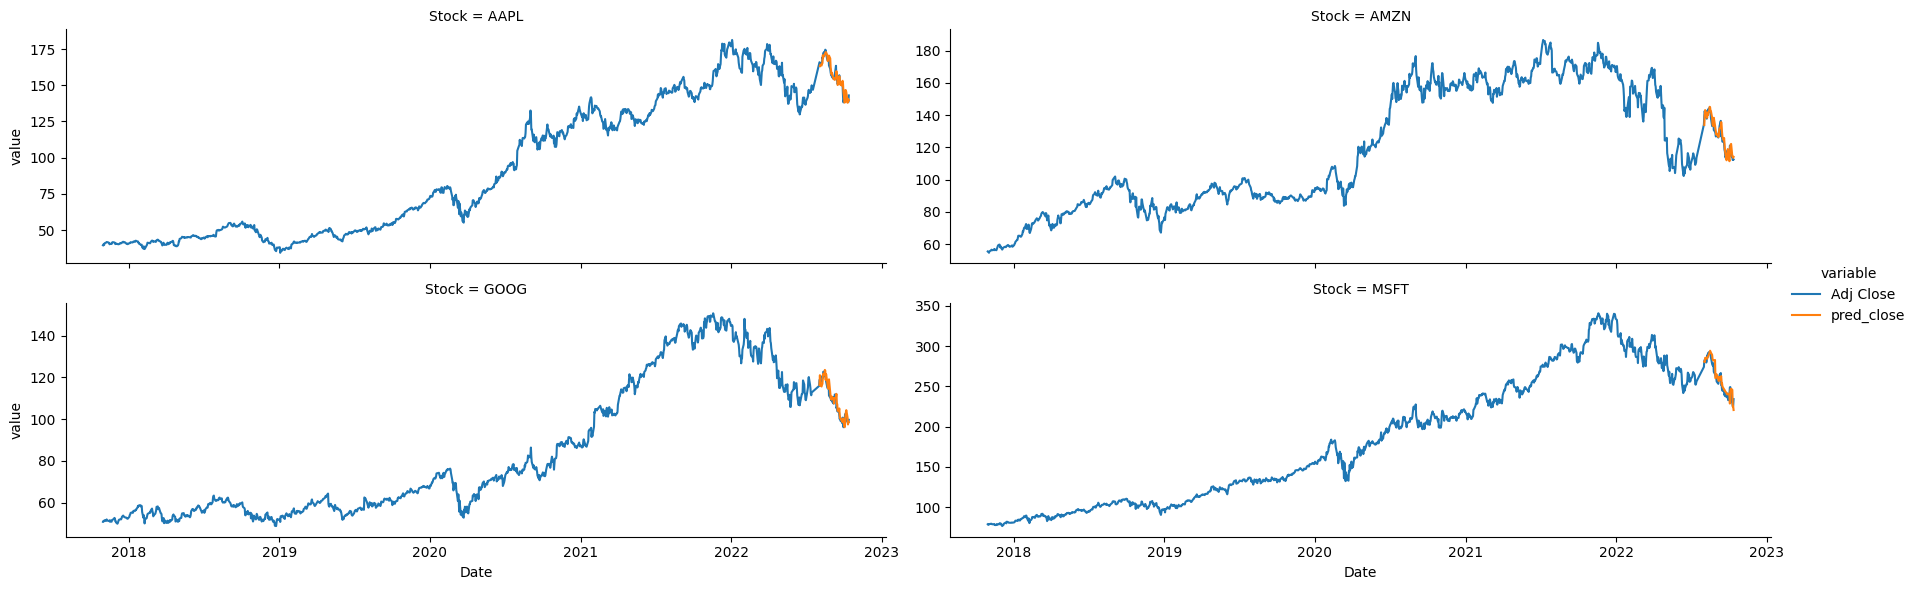

In [29]:
import seaborn as sns

g = sns.FacetGrid(melt_df, col="Stock", hue="variable", col_wrap=2, aspect=3, sharey=False)
g.map_dataframe(sns.lineplot, "Date", "value")
g.add_legend()

# TODO:
- Convert add_features to reusable pipe (see previous Kaggle work)
- Try with LSTM
- Increase lookback > DONE but means additional NaNs
- Cross validation
- Tuning

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02428734],
       [0.02524027],
       [0.02409342],
       ...,
       [0.70781589],
       [0.73947156],
       [0.70808826]])

In [ ]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.02428734, 0.02524027, 0.02409342, 0.0179879 , 0.01842392,
       0.01829483, 0.01979698, 0.01868241, 0.02029767, 0.02940757,
       0.03533547, 0.03908279, 0.03561004, 0.03758058, 0.04467151,
       0.04749815, 0.0484026 , 0.05071235, 0.05013095, 0.04919071,
       0.04805599, 0.04379271, 0.04012917, 0.04340359, 0.04186365,
       0.04158806, 0.04671053, 0.04966086, 0.04967701, 0.0482505 ,
       0.04659712, 0.04077759, 0.04461939, 0.04332257, 0.04129632,
       0.04103689, 0.04001571, 0.04051821, 0.04059918, 0.04594867,
       0.04437629, 0.04530022, 0.04521917, 0.04805599, 0.05202748,
       0.04897995, 0.04867195, 0.04974186, 0.04974186, 0.04254448,
       0.04259312, 0.04337118, 0.04037226, 0.04528399, 0.0452354 ,
       0.0465322 , 0.04972568, 0.04867195, 0.04863957, 0.04857475])]
[0.05017959225732893]

[array([0.02428734, 0.02524027, 0.02409342, 0.0179879 , 0.01842392,
       0.01829483, 0.01979698, 0.01868241, 0.02029767, 0.02940757,
       0.03533547, 0.03908279, 0.03

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1134/1134 [==============================] - 13s 10ms/step - loss: 0.0032


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 8ms/step


11.630943828671484

/tmp/ipykernel_449351/2848346960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


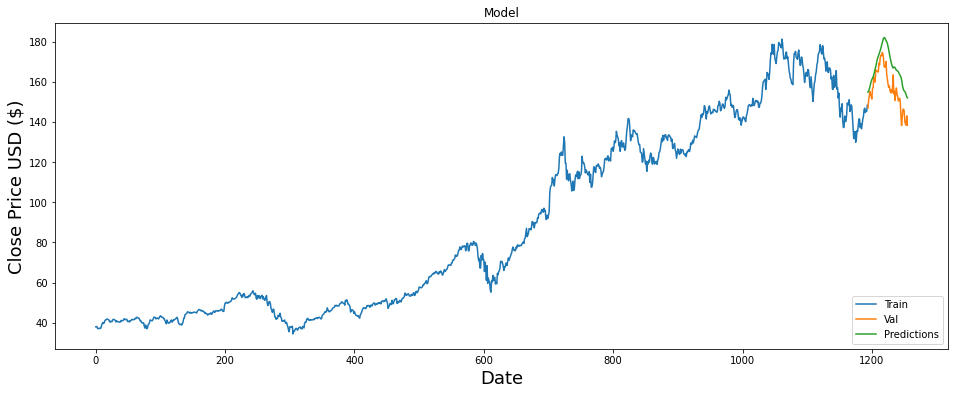

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,Adj Close,Predictions
2390,109.910004,109.561989
2391,150.790543,143.780365
2392,114.620003,113.939896
2393,152.827713,147.818787
2394,114.699997,119.149986
...,...,...
2510,98.300003,103.749290
2511,142.990005,138.259155
2512,99.709999,103.529953
2513,138.380005,141.476059
